## Introduction
Finally we are going to train our tumor segmentation network. <br />
Here we apply some small changes

## Imports:

* Pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* tqdm for progress par when validating the model
* celluloid for easy video generation
* Our dataset and model



In [1]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera

from dataset import LungDataset
from model import UNet

## Dataset Creation
Here we create the train and validation dataset. <br />
Additionally we define our data augmentation pipeline.
Subsequently the two dataloaders are created

In [2]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [3]:
# Create the dataset objects
train_path = Path("Task06_Lung/Preprocessed/train/")
val_path = Path("Task06_Lung/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 8978 train images and 0 val images


## Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
In this notebook we will use oversampling to sample slices which contain a tumor more often.

To do so we can use the **WeightedRandomSampler** provided by pytorch which needs a weight for each sample in the dataset.
Typically you have one weight for each class, which means that we need to calculate two weights, one for slices without tumors and one for slices with a tumor and create list that assigns each sample from the dataset the corresponding weight

To do so, we at first need to create a list containing only the class labels:

In [4]:
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/8978 [00:00<?, ?it/s]

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Then we can calculate the weight for each class:
To do so, we can simply compute the fraction between the classes and then create the weight list

In [5]:
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([8037,  941], dtype=int64))

In [6]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.540913921360255

Subsequently we assign the weight 1 to each slice without a tumor and ~9 to each slice with a tumor

In [7]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [8]:
weight_list[:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Finally we create the sampler which we can pass to the DataLoader.
**Important:** Only use a sampler for the train loader! We don't want to change the validation data to get a real validation

In [9]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))                     


In [10]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero

In [11]:
verify_sampler = next(iter(train_loader))  # Take one batch

In [12]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size 

tensor([False,  True,  True,  True, False, False,  True,  True])

## Loss

As this is a harder task to train you might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

## Full Segmentation Model

We now combine everything into the full pytorch lightning model

In [24]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5
        
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [25]:
# Instanciate the model
model = TumorSegmentation()

In [26]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [27]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluation:
Let's evaluate the results

In [50]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice


In [51]:
pwd

'D:\\Udemy-Medical PyTorch\\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\\Solution'

In [52]:
model = TumorSegmentation.load_from_checkpoint("../checkpoints/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\utilities\migration\migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint D:\Udemy-Medical PyTorch\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\checkpoints\epoch=29-step=53759.ckpt`


In [53]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

0it [00:00, ?it/s]

Compute overall Dice Score: This is not a bad result!
Those tumors are extremely small and already some wrongly segmented pixels strongly reduce the Dice Score.
The Visualization below demonstrates that!

In [54]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: nan


## Visualization

Feel free to play around with the threshold.

What happens if you decrease it?

In [55]:
THRESHOLD = 0.5

In [56]:
import nibabel as nib
import cv2

In [57]:
subject = Path("Task06_Lung/imagesTs/lung_013.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [58]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)
    

Plotting the predicted segmentation (red)

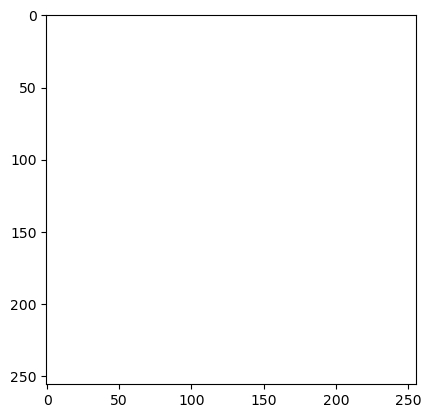

In [61]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation 
    
#     plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [60]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


RuntimeError: Requested MovieWriter (ffmpeg) not available

Congratulations! You created a lung cancer segmentation model!